In [2]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt

/home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK3c106IValue23reportToTensorTypeErrorEv
  warn(f"Failed to load image Python extension: {e}")


## Training Setup

In [7]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=16                                        
device=set_device("cuda", 0)
train_size=0.00108 / 64

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi1D     = AWLoss1DFFT(reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-15)
awi2D     = AWLoss2DFFT(reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-7)


No GPU available! Running on CPU


## Datasets and Dataloaders

In [8]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
])

ds = MNIST("../data", download=True, train=True, transform=train_transform)
try:
    shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
    train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
except:
    train_idx=[7]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())


Trainable Images: 1
torch.Size([1, 1, 28, 28]) 0.0 1.0


## Autoencoder (CNN)

In [9]:
def model_instance():
    return CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)

model_sample = model_instance()

print(model_sample)
print(X.shape, model_sample(X).shape)

CAE28(
  (activation): Mish()
  (sigmoid): Sigmoid()
  (e_cv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
  (e_cv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (e_cv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (e_fc5): Linear(in_features=128, out_features=32, bias=True)
  (d_fc1): Linear(in_features=32, out_features=128, bias=True)
  (d_cv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(3, 3))
  (d_cv3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(3, 3))
  (d_cv4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(3, 3))
)
torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


## Training MSE Loss



Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 158.97515869140625, 'mse (validation)': 0.20213495194911957, 'kl_loss': 0.0}


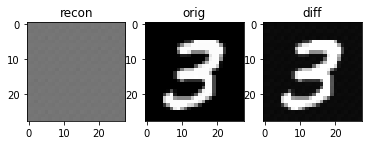

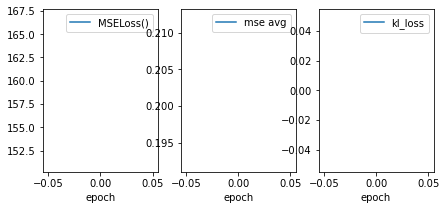

  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:10
  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:46
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:37
  4% (4 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:33
  5% (5 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:30
  6% (6 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:28
  7% (7 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:26
  8% (8 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:25
  9% (9 of 100) |##                      | Elapsed Time: 0:00:02 ETA:   0:00:24
 10% (10 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:23
 11% (11 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:18
 12% (12 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:18
 13% (13 of 100) |##                    


 {'epoch': 20, 'loss': 36.06898880004883, 'mse (validation)': 0.0378057025372982, 'kl_loss': 0.0}


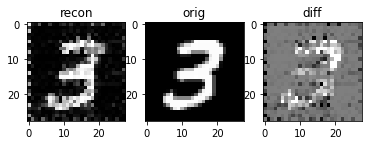

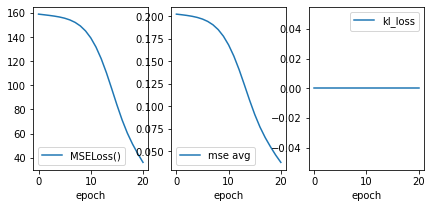

 21% (21 of 100) |####                   | Elapsed Time: 0:00:05 ETA:   0:00:21
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:05 ETA:   0:00:21
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:05 ETA:   0:00:21
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:21
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:21
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:20
 27% (27 of 100) |######                 | Elapsed Time: 0:00:06 ETA:   0:00:20
 28% (28 of 100) |######                 | Elapsed Time: 0:00:06 ETA:   0:00:19
 29% (29 of 100) |######                 | Elapsed Time: 0:00:07 ETA:   0:00:19
 30% (30 of 100) |######                 | Elapsed Time: 0:00:07 ETA:   0:00:18
 31% (31 of 100) |#######                | Elapsed Time: 0:00:07 ETA:   0:00:15
 32% (32 of 100) |#######                | Elapsed Time: 0:00:07 ETA:   0:00:14
 33% (33 of 100) |#######               


 {'epoch': 40, 'loss': 3.7729711532592773, 'mse (validation)': 0.004723527934402227, 'kl_loss': 0.0}


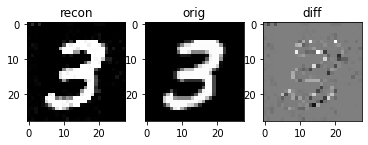

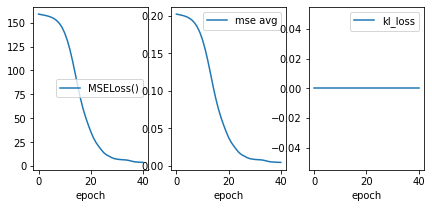

 41% (41 of 100) |#########              | Elapsed Time: 0:00:10 ETA:   0:00:15
 42% (42 of 100) |#########              | Elapsed Time: 0:00:10 ETA:   0:00:15
 43% (43 of 100) |#########              | Elapsed Time: 0:00:10 ETA:   0:00:14
 44% (44 of 100) |##########             | Elapsed Time: 0:00:10 ETA:   0:00:14
 45% (45 of 100) |##########             | Elapsed Time: 0:00:10 ETA:   0:00:14
 46% (46 of 100) |##########             | Elapsed Time: 0:00:11 ETA:   0:00:13
 47% (47 of 100) |##########             | Elapsed Time: 0:00:11 ETA:   0:00:13
 48% (48 of 100) |###########            | Elapsed Time: 0:00:11 ETA:   0:00:13
 49% (49 of 100) |###########            | Elapsed Time: 0:00:11 ETA:   0:00:12
 50% (50 of 100) |###########            | Elapsed Time: 0:00:12 ETA:   0:00:12
 51% (51 of 100) |###########            | Elapsed Time: 0:00:12 ETA:   0:00:10
 52% (52 of 100) |###########            | Elapsed Time: 0:00:12 ETA:   0:00:09
 53% (53 of 100) |############          


 {'epoch': 60, 'loss': 2.233659029006958, 'mse (validation)': 0.0028071817941963673, 'kl_loss': 0.0}


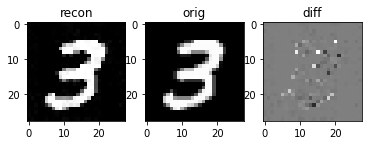

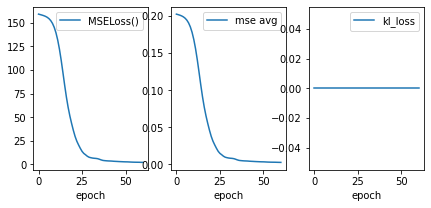

 61% (61 of 100) |##############         | Elapsed Time: 0:00:14 ETA:   0:00:11
 62% (62 of 100) |##############         | Elapsed Time: 0:00:15 ETA:   0:00:10
 63% (63 of 100) |##############         | Elapsed Time: 0:00:15 ETA:   0:00:10
 64% (64 of 100) |##############         | Elapsed Time: 0:00:15 ETA:   0:00:10
 65% (65 of 100) |##############         | Elapsed Time: 0:00:15 ETA:   0:00:10
 66% (66 of 100) |###############        | Elapsed Time: 0:00:16 ETA:   0:00:09
 67% (67 of 100) |###############        | Elapsed Time: 0:00:16 ETA:   0:00:09
 68% (68 of 100) |###############        | Elapsed Time: 0:00:16 ETA:   0:00:09
 69% (69 of 100) |###############        | Elapsed Time: 0:00:16 ETA:   0:00:08
 70% (70 of 100) |################       | Elapsed Time: 0:00:16 ETA:   0:00:06
 71% (71 of 100) |################       | Elapsed Time: 0:00:17 ETA:   0:00:06
 72% (72 of 100) |################       | Elapsed Time: 0:00:17 ETA:   0:00:06
 73% (73 of 100) |################      


 {'epoch': 80, 'loss': 1.7700526714324951, 'mse (validation)': 0.0022448115050792694, 'kl_loss': 0.0}


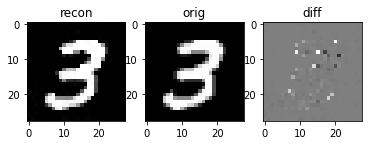

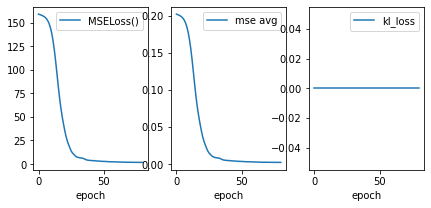

 81% (81 of 100) |##################     | Elapsed Time: 0:00:19 ETA:   0:00:05
 82% (82 of 100) |##################     | Elapsed Time: 0:00:20 ETA:   0:00:04
 83% (83 of 100) |###################    | Elapsed Time: 0:00:20 ETA:   0:00:04
 84% (84 of 100) |###################    | Elapsed Time: 0:00:20 ETA:   0:00:04
 85% (85 of 100) |###################    | Elapsed Time: 0:00:20 ETA:   0:00:04
 86% (86 of 100) |###################    | Elapsed Time: 0:00:20 ETA:   0:00:03
 87% (87 of 100) |####################   | Elapsed Time: 0:00:21 ETA:   0:00:03
 88% (88 of 100) |####################   | Elapsed Time: 0:00:21 ETA:   0:00:03
 89% (89 of 100) |####################   | Elapsed Time: 0:00:21 ETA:   0:00:02
 90% (90 of 100) |####################   | Elapsed Time: 0:00:21 ETA:   0:00:02
 91% (91 of 100) |####################   | Elapsed Time: 0:00:22 ETA:   0:00:01
 92% (92 of 100) |#####################  | Elapsed Time: 0:00:22 ETA:   0:00:01
 93% (93 of 100) |##################### 


 {'epoch': 99, 'loss': 1.6061217784881592, 'mse (validation)': 0.0020521823316812515, 'kl_loss': 0.0}


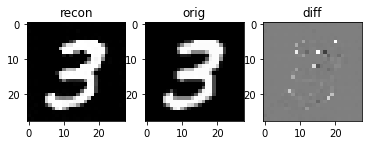

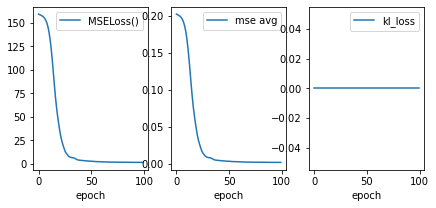

100% (100 of 100) |######################| Elapsed Time: 0:00:24 Time:  0:00:24


In [10]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, l2loss, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)

### Loss Landscape

In [11]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)

## Training AWLoss1D



Training started ...


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 0.7027159929275513, 'mse (validation)': 0.22843657433986664, 'kl_loss': 0.0}
 argidx T, v:  783 1434


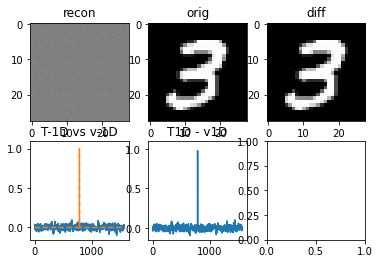

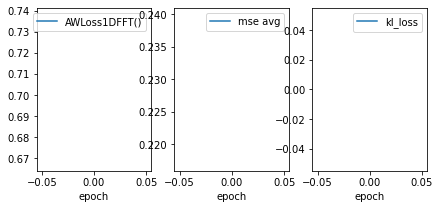

  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:15
  2% (2 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:00:48
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:39
  4% (4 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:34
  5% (5 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:31
  6% (6 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:30
  7% (7 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:28
  8% (8 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:27
  9% (9 of 100) |##                      | Elapsed Time: 0:00:02 ETA:   0:00:26
 10% (10 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:21
 11% (11 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:21
 12% (12 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:21
 13% (13 of 100) |##                    


 {'epoch': 20, 'loss': 0.47688695788383484, 'mse (validation)': 0.22757001221179962, 'kl_loss': 0.0}
 argidx T, v:  783 783


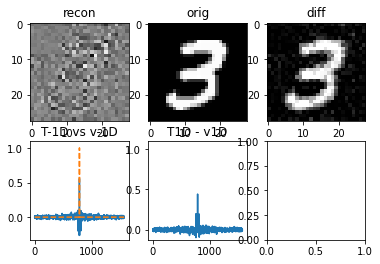

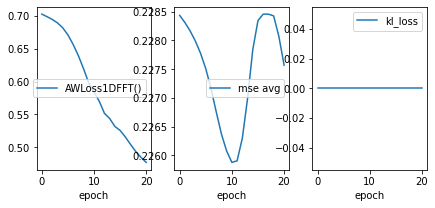

 21% (21 of 100) |####                   | Elapsed Time: 0:00:06 ETA:   0:00:25
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:24
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:23
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:23
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:07 ETA:   0:00:23
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:07 ETA:   0:00:22
 27% (27 of 100) |######                 | Elapsed Time: 0:00:07 ETA:   0:00:22
 28% (28 of 100) |######                 | Elapsed Time: 0:00:07 ETA:   0:00:21
 29% (29 of 100) |######                 | Elapsed Time: 0:00:08 ETA:   0:00:20
 30% (30 of 100) |######                 | Elapsed Time: 0:00:08 ETA:   0:00:16
 31% (31 of 100) |#######                | Elapsed Time: 0:00:08 ETA:   0:00:16
 32% (32 of 100) |#######                | Elapsed Time: 0:00:08 ETA:   0:00:16
 33% (33 of 100) |#######               


 {'epoch': 40, 'loss': 0.35181882977485657, 'mse (validation)': 0.22091752290725708, 'kl_loss': 0.0}
 argidx T, v:  783 783


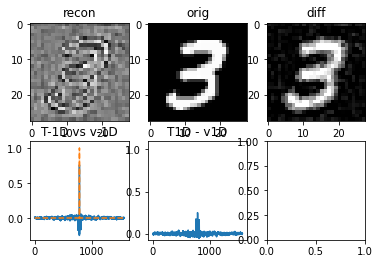

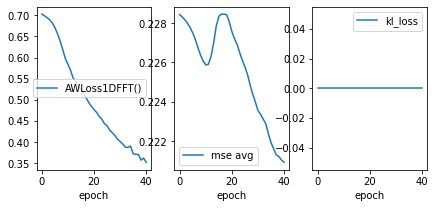

 41% (41 of 100) |#########              | Elapsed Time: 0:00:11 ETA:   0:00:20
 42% (42 of 100) |#########              | Elapsed Time: 0:00:11 ETA:   0:00:19
 43% (43 of 100) |#########              | Elapsed Time: 0:00:11 ETA:   0:00:19
 44% (44 of 100) |##########             | Elapsed Time: 0:00:12 ETA:   0:00:19
 45% (45 of 100) |##########             | Elapsed Time: 0:00:12 ETA:   0:00:18
 46% (46 of 100) |##########             | Elapsed Time: 0:00:12 ETA:   0:00:18
 47% (47 of 100) |##########             | Elapsed Time: 0:00:12 ETA:   0:00:17
 48% (48 of 100) |###########            | Elapsed Time: 0:00:13 ETA:   0:00:16
 49% (49 of 100) |###########            | Elapsed Time: 0:00:13 ETA:   0:00:15
 50% (50 of 100) |###########            | Elapsed Time: 0:00:13 ETA:   0:00:11
 51% (51 of 100) |###########            | Elapsed Time: 0:00:13 ETA:   0:00:11
 52% (52 of 100) |###########            | Elapsed Time: 0:00:14 ETA:   0:00:11
 53% (53 of 100) |############          


 {'epoch': 60, 'loss': 0.29121991991996765, 'mse (validation)': 0.21351097524166107, 'kl_loss': 0.0}
 argidx T, v:  783 783


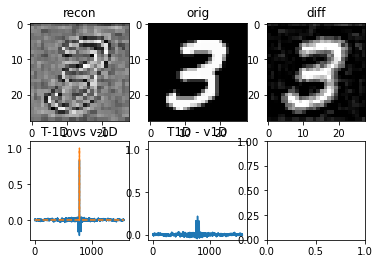

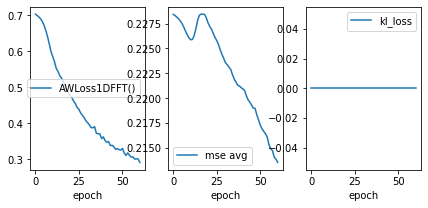

 61% (61 of 100) |##############         | Elapsed Time: 0:00:16 ETA:   0:00:13
 62% (62 of 100) |##############         | Elapsed Time: 0:00:17 ETA:   0:00:13
 63% (63 of 100) |##############         | Elapsed Time: 0:00:17 ETA:   0:00:12
 64% (64 of 100) |##############         | Elapsed Time: 0:00:17 ETA:   0:00:12
 65% (65 of 100) |##############         | Elapsed Time: 0:00:17 ETA:   0:00:11
 66% (66 of 100) |###############        | Elapsed Time: 0:00:18 ETA:   0:00:11
 67% (67 of 100) |###############        | Elapsed Time: 0:00:18 ETA:   0:00:10
 68% (68 of 100) |###############        | Elapsed Time: 0:00:18 ETA:   0:00:10
 69% (69 of 100) |###############        | Elapsed Time: 0:00:19 ETA:   0:00:08
 70% (70 of 100) |################       | Elapsed Time: 0:00:19 ETA:   0:00:07
 71% (71 of 100) |################       | Elapsed Time: 0:00:19 ETA:   0:00:07
 72% (72 of 100) |################       | Elapsed Time: 0:00:19 ETA:   0:00:07
 73% (73 of 100) |################      


 {'epoch': 80, 'loss': 0.2658393979072571, 'mse (validation)': 0.20480145514011383, 'kl_loss': 0.0}
 argidx T, v:  783 783


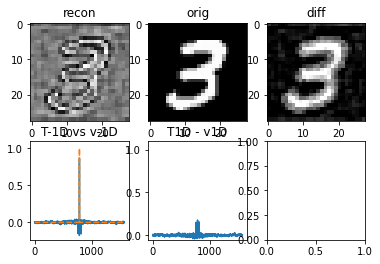

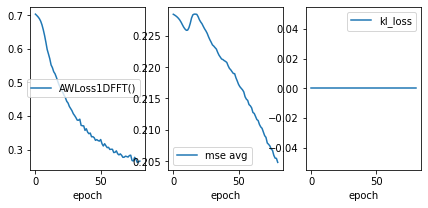

 81% (81 of 100) |##################     | Elapsed Time: 0:00:22 ETA:   0:00:06
 82% (82 of 100) |##################     | Elapsed Time: 0:00:22 ETA:   0:00:06
 83% (83 of 100) |###################    | Elapsed Time: 0:00:23 ETA:   0:00:06
 84% (84 of 100) |###################    | Elapsed Time: 0:00:23 ETA:   0:00:05
 85% (85 of 100) |###################    | Elapsed Time: 0:00:23 ETA:   0:00:05
 86% (86 of 100) |###################    | Elapsed Time: 0:00:23 ETA:   0:00:04
 87% (87 of 100) |####################   | Elapsed Time: 0:00:24 ETA:   0:00:04
 88% (88 of 100) |####################   | Elapsed Time: 0:00:24 ETA:   0:00:03
 89% (89 of 100) |####################   | Elapsed Time: 0:00:24 ETA:   0:00:03
 90% (90 of 100) |####################   | Elapsed Time: 0:00:24 ETA:   0:00:02
 91% (91 of 100) |####################   | Elapsed Time: 0:00:25 ETA:   0:00:02
 92% (92 of 100) |#####################  | Elapsed Time: 0:00:25 ETA:   0:00:01
 93% (93 of 100) |##################### 


 {'epoch': 99, 'loss': 0.2348487228155136, 'mse (validation)': 0.19763849675655365, 'kl_loss': 0.0}
 argidx T, v:  783 783


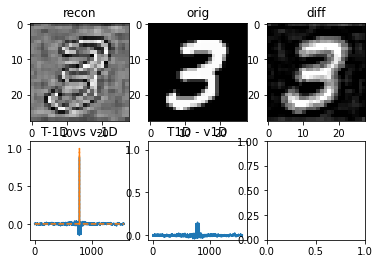

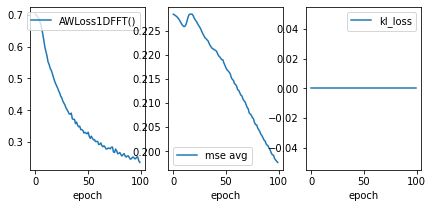

100% (100 of 100) |######################| Elapsed Time: 0:00:27 Time:  0:00:27


In [15]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, awi1D, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)

### Loss Landscape

In [16]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)

## Training AWLoss2D



Training started ...


/home/dekape/miniconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /tmp/pip-req-build-9n7gsq15/aten/src/ATen/native/Copy.cpp:219.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--



 {'epoch': 0, 'loss': 0.7147322297096252, 'mse (validation)': 0.25943300127983093, 'kl_loss': 0.0}
 argidx T, v:  1512 2480


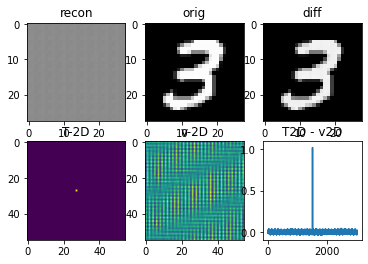

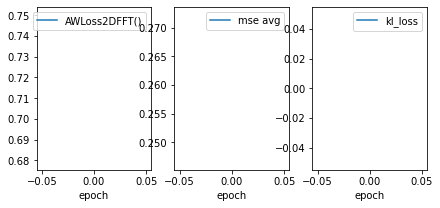

  1% (1 of 100) |                        | Elapsed Time: 0:00:00 ETA:   0:01:18
  2% (2 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:51
  3% (3 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:41
  4% (4 of 100) |                        | Elapsed Time: 0:00:01 ETA:   0:00:36
  5% (5 of 100) |#                       | Elapsed Time: 0:00:01 ETA:   0:00:33
  6% (6 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:31
  7% (7 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:30
  8% (8 of 100) |#                       | Elapsed Time: 0:00:02 ETA:   0:00:28
  9% (9 of 100) |##                      | Elapsed Time: 0:00:02 ETA:   0:00:27
 10% (10 of 100) |##                     | Elapsed Time: 0:00:02 ETA:   0:00:22
 11% (11 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:21
 12% (12 of 100) |##                     | Elapsed Time: 0:00:03 ETA:   0:00:21
 13% (13 of 100) |##                    


 {'epoch': 20, 'loss': 0.6131328344345093, 'mse (validation)': 0.2788074314594269, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


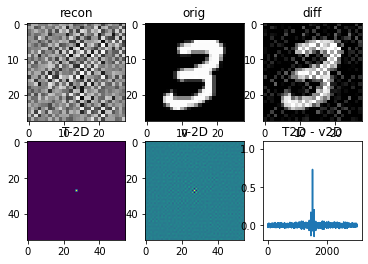

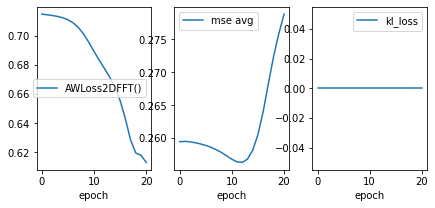

 21% (21 of 100) |####                   | Elapsed Time: 0:00:06 ETA:   0:00:27
 22% (22 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:26
 23% (23 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:26
 24% (24 of 100) |#####                  | Elapsed Time: 0:00:06 ETA:   0:00:25
 25% (25 of 100) |#####                  | Elapsed Time: 0:00:07 ETA:   0:00:25
 26% (26 of 100) |#####                  | Elapsed Time: 0:00:07 ETA:   0:00:24
 27% (27 of 100) |######                 | Elapsed Time: 0:00:07 ETA:   0:00:23
 28% (28 of 100) |######                 | Elapsed Time: 0:00:07 ETA:   0:00:22
 29% (29 of 100) |######                 | Elapsed Time: 0:00:08 ETA:   0:00:21
 30% (30 of 100) |######                 | Elapsed Time: 0:00:08 ETA:   0:00:17
 31% (31 of 100) |#######                | Elapsed Time: 0:00:08 ETA:   0:00:16
 32% (32 of 100) |#######                | Elapsed Time: 0:00:08 ETA:   0:00:16
 33% (33 of 100) |#######               


 {'epoch': 40, 'loss': 0.4959731101989746, 'mse (validation)': 0.27210938930511475, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


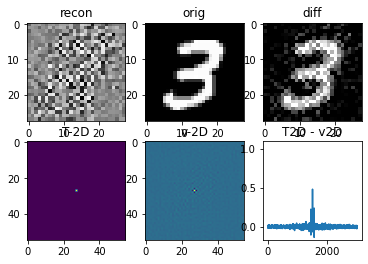

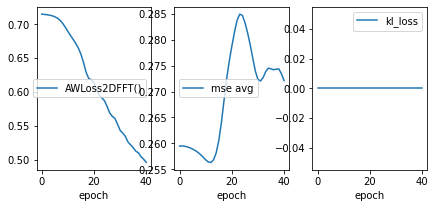

 41% (41 of 100) |#########              | Elapsed Time: 0:00:11 ETA:   0:00:21
 42% (42 of 100) |#########              | Elapsed Time: 0:00:12 ETA:   0:00:20
 43% (43 of 100) |#########              | Elapsed Time: 0:00:12 ETA:   0:00:20
 44% (44 of 100) |##########             | Elapsed Time: 0:00:12 ETA:   0:00:20
 45% (45 of 100) |##########             | Elapsed Time: 0:00:12 ETA:   0:00:19
 46% (46 of 100) |##########             | Elapsed Time: 0:00:13 ETA:   0:00:19
 47% (47 of 100) |##########             | Elapsed Time: 0:00:13 ETA:   0:00:18
 48% (48 of 100) |###########            | Elapsed Time: 0:00:13 ETA:   0:00:17
 49% (49 of 100) |###########            | Elapsed Time: 0:00:13 ETA:   0:00:13
 50% (50 of 100) |###########            | Elapsed Time: 0:00:14 ETA:   0:00:13
 51% (51 of 100) |###########            | Elapsed Time: 0:00:14 ETA:   0:00:13
 52% (52 of 100) |###########            | Elapsed Time: 0:00:14 ETA:   0:00:12
 53% (53 of 100) |############          


 {'epoch': 60, 'loss': 0.4212574064731598, 'mse (validation)': 0.2611925005912781, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


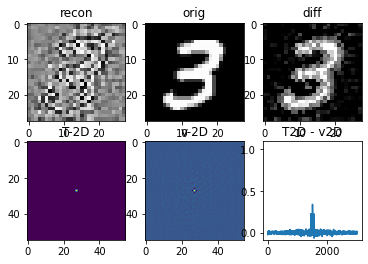

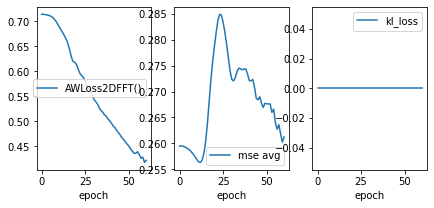

 61% (61 of 100) |##############         | Elapsed Time: 0:00:18 ETA:   0:00:42
 62% (62 of 100) |##############         | Elapsed Time: 0:00:19 ETA:   0:00:30
 63% (63 of 100) |##############         | Elapsed Time: 0:00:19 ETA:   0:00:25
 64% (64 of 100) |##############         | Elapsed Time: 0:00:19 ETA:   0:00:21
 65% (65 of 100) |##############         | Elapsed Time: 0:00:19 ETA:   0:00:14
 66% (66 of 100) |###############        | Elapsed Time: 0:00:20 ETA:   0:00:13
 67% (67 of 100) |###############        | Elapsed Time: 0:00:20 ETA:   0:00:12
 68% (68 of 100) |###############        | Elapsed Time: 0:00:20 ETA:   0:00:11
 69% (69 of 100) |###############        | Elapsed Time: 0:00:20 ETA:   0:00:08
 70% (70 of 100) |################       | Elapsed Time: 0:00:21 ETA:   0:00:07
 71% (71 of 100) |################       | Elapsed Time: 0:00:21 ETA:   0:00:07
 72% (72 of 100) |################       | Elapsed Time: 0:00:21 ETA:   0:00:07
 73% (73 of 100) |################      


 {'epoch': 80, 'loss': 0.3670682907104492, 'mse (validation)': 0.25678256154060364, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


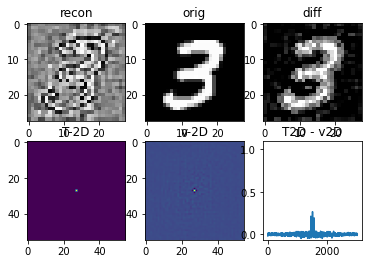

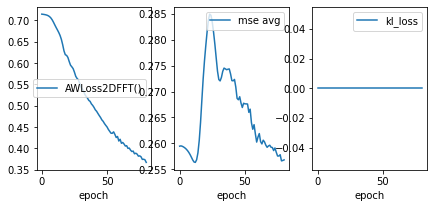

 81% (81 of 100) |##################     | Elapsed Time: 0:00:24 ETA:   0:00:07
 82% (82 of 100) |##################     | Elapsed Time: 0:00:25 ETA:   0:00:07
 83% (83 of 100) |###################    | Elapsed Time: 0:00:25 ETA:   0:00:07
 84% (84 of 100) |###################    | Elapsed Time: 0:00:25 ETA:   0:00:08
 85% (85 of 100) |###################    | Elapsed Time: 0:00:26 ETA:   0:00:07
 86% (86 of 100) |###################    | Elapsed Time: 0:00:26 ETA:   0:00:06
 87% (87 of 100) |####################   | Elapsed Time: 0:00:26 ETA:   0:00:04
 88% (88 of 100) |####################   | Elapsed Time: 0:00:27 ETA:   0:00:03
 89% (89 of 100) |####################   | Elapsed Time: 0:00:27 ETA:   0:00:03
 90% (90 of 100) |####################   | Elapsed Time: 0:00:27 ETA:   0:00:03
 91% (91 of 100) |####################   | Elapsed Time: 0:00:27 ETA:   0:00:02
 92% (92 of 100) |#####################  | Elapsed Time: 0:00:28 ETA:   0:00:02
 93% (93 of 100) |##################### 


 {'epoch': 99, 'loss': 0.3435715138912201, 'mse (validation)': 0.25169986486434937, 'kl_loss': 0.0}
 argidx T, v:  1512 1512


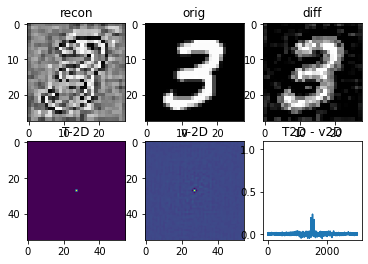

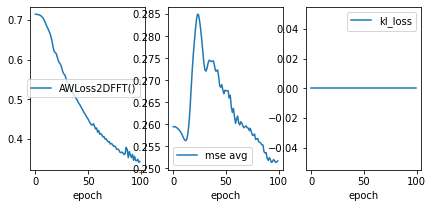

100% (100 of 100) |######################| Elapsed Time: 0:00:31 Time:  0:00:31


In [17]:
model = model_instance()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_model(model, optimizer, train_loader, awi2D, nepochs, log_frequency=20, sample=X, device=device, gradflow=False)

### Loss Landscape

In [18]:
# train_subset = Subset(trainds, list(np.random.randint(0, len(trainds), size=16)))
# train_subloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
# print("Train Subset len: ", len(train_subset))
# xx, yy, loss_landscape = visualise_landscape(model, train_subloader, awi1D, device=device)